# Prepare Dataset

In [2]:
import os

base_dir = "../datasets/"
samples_dir = os.path.join(base_dir, 'samples/')

# Datasets Dir
corn_dir = os.path.join(samples_dir, 'corn/')
weed_dir = os.path.join(samples_dir, 'weed/')

# Train, Test, Validation Dir
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

# Train, Test, Validation Corn Dir
train_corn_dir = os.path.join(train_dir, 'corn/')
test_corn_dir = os.path.join(test_dir, 'corn/')

# Train, Test, Validation Weed Dir
train_weed_dir = os.path.join(train_dir, 'weed/')
test_weed_dir = os.path.join(test_dir, 'weed/')

In [5]:
import random
from shutil import copyfile


def split_data(SOURCE, TRAINING, TESTING, RATIO):
    if not os.path.exists(TRAINING):
        os.makedirs(TRAINING)
    if not os.path.exists(TESTING):
        os.makedirs(TESTING)

    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * RATIO)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


if not os.path.exists(train_dir):
    ratio = 0.9
    split_data(corn_dir, train_corn_dir, test_corn_dir, ratio)
    split_data(weed_dir, train_weed_dir, test_weed_dir, ratio)

print('total training corn images (90%):', len(os.listdir(train_corn_dir)))
print('total testing corn images (10%):', len(os.listdir(test_corn_dir)))
print('total training weed images (90%):', len(os.listdir(train_weed_dir)))
print('total testing weed images (10%):', len(os.listdir(test_weed_dir)))


total training corn images (90%): 2446
total testing corn images (10%): 272
total training weed images (90%): 811
total testing weed images (10%): 91


# Preprocessing, Augmentation

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.1,
)

Found 3257 images belonging to 2 classes.


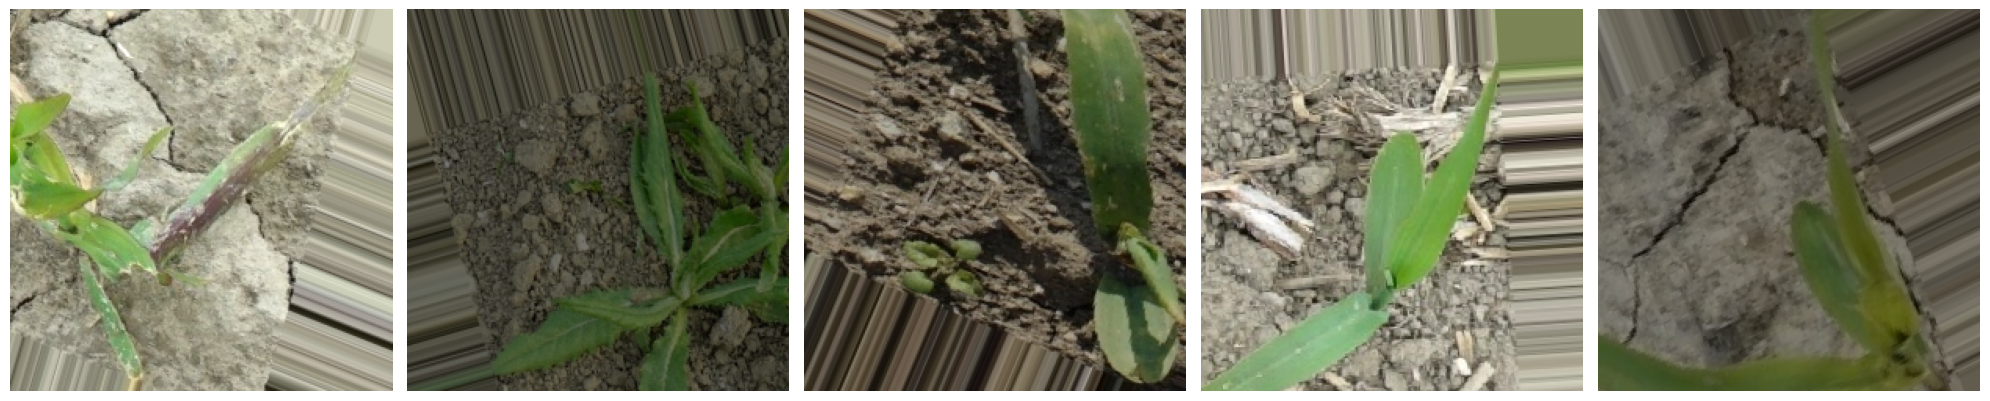

In [5]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=16,
    class_mode='categorical',
))


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:5])

# Segmentation

In [6]:
# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=16,
    class_mode='categorical',
)

# Flow validation images in batches of 16 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(244, 244),
    batch_size=16,
    class_mode='categorical',
)

Found 3257 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


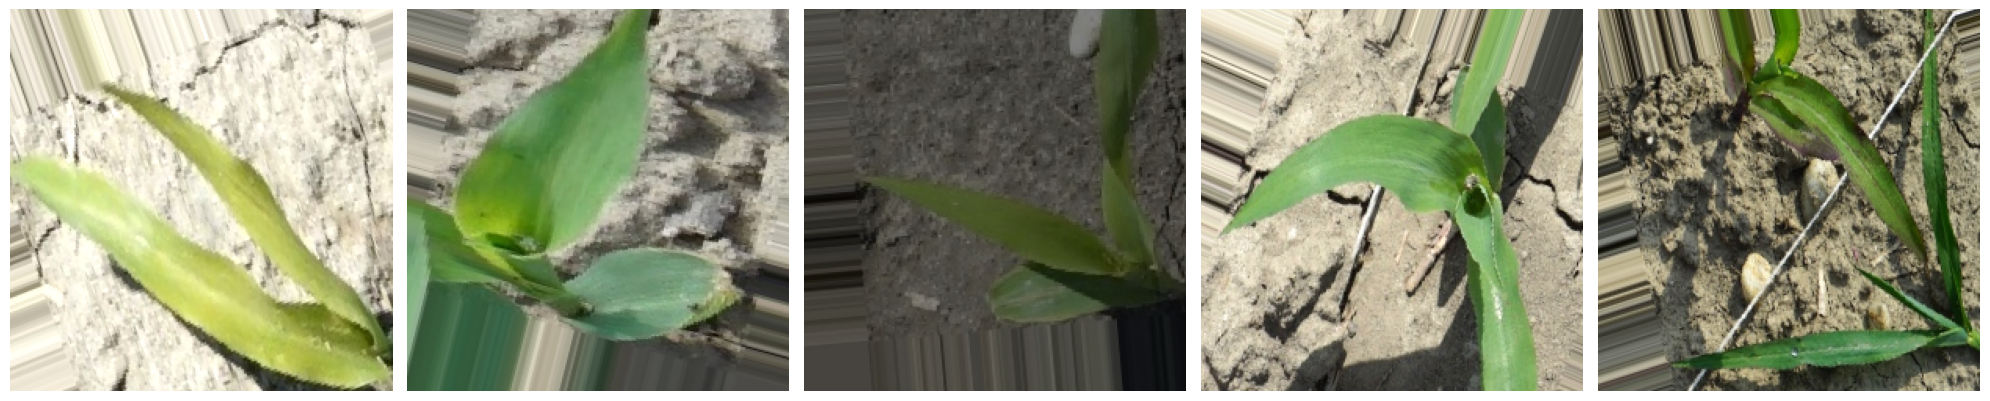

In [7]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:5])

# Feature Extraction

In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 121, 121, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 64)        1

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback Function

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if (logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True


callbacks = myCallback()

In [13]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/50
204/204 [==============================] - 145s 698ms/step - loss: 0.6220 - accuracy: 0.7455 - val_loss: 0.4925 - val_accuracy: 0.7989
Epoch 2/50
204/204 [==============================] - 99s 483ms/step - loss: 0.5422 - accuracy: 0.7574 - val_loss: 0.4957 - val_accuracy: 0.7658
Epoch 3/50
204/204 [==============================] - 98s 482ms/step - loss: 0.4891 - accuracy: 0.7866 - val_loss: 0.5148 - val_accuracy: 0.8044
Epoch 4/50
204/204 [==============================] - 99s 483ms/step - loss: 0.4303 - accuracy: 0.8247 - val_loss: 0.3818 - val_accuracy: 0.8292
Epoch 5/50
204/204 [==============================] - 99s 483ms/step - loss: 0.3882 - accuracy: 0.8465 - val_loss: 0.3856 - val_accuracy: 0.8402
Epoch 6/50
204/204 [==============================] - 98s 481ms/step - loss: 0.3616 - accuracy: 0.8585 - val_loss: 0.4100 - val_accuracy: 0.8430
Epoch 7/50
204/204 [==============================] - 99s 483ms/step - loss: 0.3770 - accuracy: 0.8489 - val_loss: 0.4132 - val_a

In [14]:
model.save('model.h5')

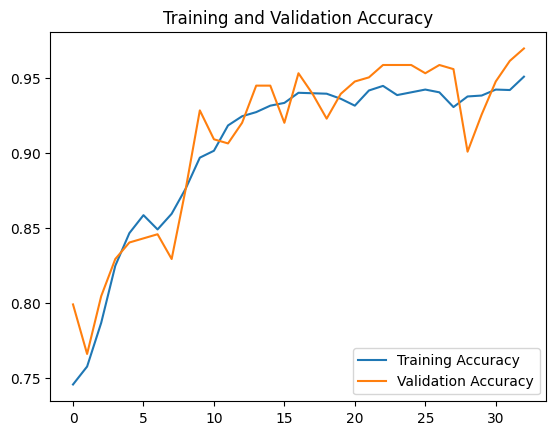

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

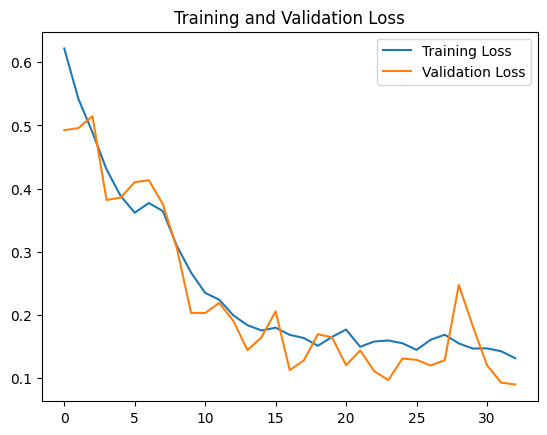

In [16]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

In [17]:
from skimage import io
import cv2
from tensorflow.keras.preprocessing import image
import os
import tensorflow as tf
import numpy as np

1/1 [==============================] - 0s 94ms/step
[[1. 0.]] ['corn', 'weed']


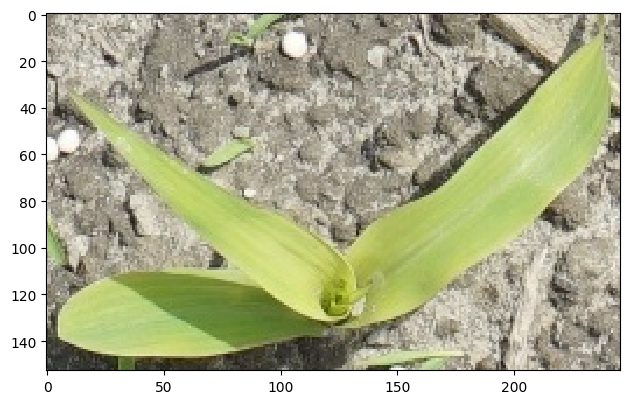

In [25]:
reconstructed_model = tf.keras.models.load_model("model.h5")

source = '../images/testing/ave-0057-0012_corn_55.jpg'

img = image.load_img(source, target_size=(244, 244))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

pred = reconstructed_model.predict(images, batch_size=10)

classes = np.argmax(pred, axis=1)

labels = ['corn', 'weed']

# image not corn or weed then print image not corn or weed
print(pred, labels)

io.imshow(source)